# **Инициализация расположения проектных скважин в перспективной зоне бурения**

Использование алгоритма **K-Means** для размещения проектных скважин внутри перспективных зон (полигонов).  
После начального размещения выполняется смещение и вращение скважин с целью:  
- предотвращения пересечений с фактическим фондом скважин;  
- исключения пересечений между проектными скважинами.

In [1]:
import pandas as pd
import numpy as np
import pickle
import os
import sys
from shapely.geometry import Point, LineString, Polygon, MultiPolygon
from shapely.ops import unary_union
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import geopandas as gpd
from scipy.spatial import KDTree
from shapely.affinity import translate
from shapely.ops import nearest_points
from shapely.affinity import rotate

In [2]:
%matplotlib inline

In [3]:
# Папка с файлом jupyter
current_folder_name = os.path.basename(os.getcwd()) 
# Папка, в которую будут сохраняться картинки
path = "images"
os.makedirs(path, exist_ok=True)
save_directory = os.path.join(current_folder_name, "images")

In [4]:
# Установите корневую директорию проекта как текущий рабочий каталог
project_root = r"C:/Users/Alina/Desktop/Python/!Работа IT ННГ/Infill_drilling/Infill_drilling"
os.chdir(project_root)
sys.path.append(os.path.abspath("app"))

## Загрузка данных из pickle

In [5]:
# Загрузка объектов из файлов
with open(f"{current_folder_name}/input/list_zones.pkl", 'rb') as f:
    list_zones = pickle.load(f)

with open(f"{current_folder_name}/input/maps.pkl", 'rb') as f:
    maps = pickle.load(f)

with open(f"{current_folder_name}/input/data_wells.pkl", 'rb') as f:
    data_wells = pickle.load(f)

data_wells = data_wells[(data_wells['Qo_cumsum'] > 0) | (data_wells['Winj_cumsum'] > 0)].reset_index(drop=True)

## Параметры расчета

In [6]:
default_size_pixel = 50  # размер ячейки карты в м = int/None
init_profit_cum_oil = 35  # условная величина минимально рентабельной НДН (количество ОИЗ) на одну скважины, тыс.т 
area_cell = default_size_pixel**2

## Работы с зонами
### Инициируем количество скважин
Используем условный минимально рентабельную НДН на скважину:  

$$
num\_project\_wells = \frac{reserves\_area}{init\_profit\_cum\_oil}
$$

In [7]:
# снимаем значения с карт
type_map_list = list(map(lambda raster: raster.type_map, maps))

# инициализация карты ОИЗ
map_residual_recoverable_reserves = maps[type_map_list.index("residual_recoverable_reserves")]

In [8]:
# для каждой зоны считаем ОИЗ и максимальное количество скважин с init_profit_cum_oil
num_zone = 0
for zone in list_zones:
    print(num_zone)
    x_coord, y_coord = zone.x_coordinates, zone.y_coordinates
    array_rrr = map_residual_recoverable_reserves.data[y_coord, x_coord]
    value_rrr = np.sum(array_rrr * area_cell / 10000) / 1000
    num_project_wells = value_rrr // init_profit_cum_oil
    print(f'ОИЗ - {value_rrr}')
    print(f'кол-во скважин - {num_project_wells}')
    num_zone += 1

0
ОИЗ - 140.939875
кол-во скважин - 4.0
1
ОИЗ - 303.98021875
кол-во скважин - 8.0
2
ОИЗ - 41.08730859375
кол-во скважин - 1.0
3
ОИЗ - 9.7490107421875
кол-во скважин - 0.0
4
ОИЗ - 8.9054296875
кол-во скважин - 0.0
5
ОИЗ - 18.060658203125
кол-во скважин - 0.0
6
ОИЗ - 99.620984375
кол-во скважин - 2.0
7
ОИЗ - 68.2155625
кол-во скважин - 1.0
8
ОИЗ - 30.79006640625
кол-во скважин - 0.0
9
ОИЗ - 8.78594140625
кол-во скважин - 0.0
10
ОИЗ - 9921.545
кол-во скважин - 283.0
11
ОИЗ - 40.545765625
кол-во скважин - 1.0
12
ОИЗ - 11.42809765625
кол-во скважин - 0.0
13
ОИЗ - 7.33369677734375
кол-во скважин - 0.0
14
ОИЗ - 5.3243857421875
кол-во скважин - 0.0
15
ОИЗ - 4.711201171875
кол-во скважин - 0.0
16
ОИЗ - 3.351549072265625
кол-во скважин - 0.0
17
ОИЗ - 10.7076220703125
кол-во скважин - 0.0


## **Расчет на примере одной зоны №10**
### Шаг 1 - Кластеризация k-means с целью определения области для каждой скважины
* Разбиваем перспективную зону на кластеры, в которых будут располагаться проектные скважины. Начальное количество кластеров соответствует **num_project_wells**.  
* В каждом кластере запасов должно быть больше или равно чем **init_profit_cum_oil**. Если условие не выполняется, то уменьшаем количество кластеров (скважин) на 1 и заново кластеризуем.
* Кластеризацию выполняем до тех пор, пока в каждом кластере не будет необходимого количества запасов.

In [9]:
num_cluster = 10
zone = list_zones[num_cluster]
value_OI = zone.opportunity_index_values

In [10]:
# Координаты зон (полигонов)
x_coord, y_coord = zone.x_coordinates, zone.y_coordinates

In [11]:
# Определение количества проектных скважин - количество кластеров на основе минимально рентабельной НДН
array_rrr = map_residual_recoverable_reserves.data[y_coord, x_coord]
value_rrr = np.sum(array_rrr * area_cell / 10000) / 1000
num_project_wells = int(value_rrr // init_profit_cum_oil)
print(f'ОИЗ - {value_rrr}')
print(f'кол-во скважин - {num_project_wells}')

ОИЗ - 9921.545
кол-во скважин - 283


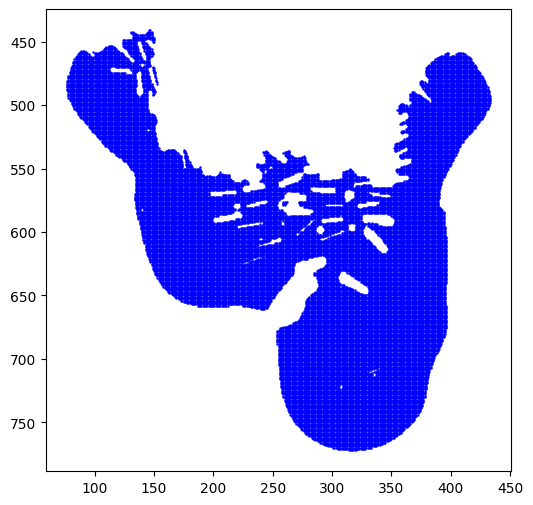

In [12]:
# Визуализация зоны
plt.figure(figsize=(6, 6))
plt.scatter(x_coord, y_coord, color='blue', s=0.5)
plt.gca().invert_yaxis()
plt.show()

In [13]:
# Кластеризация зоны методом k-means, критерий: в каждой зоне должно быть достаточно запасов
points = np.column_stack((x_coord, y_coord))
while True:
    kmeans = KMeans(n_clusters=num_project_wells, max_iter=300,  random_state=42) #, algorithm='elkan') #, init='random') random_state=42) - даст одинаковые результаты при разных вызовах 
    kmeans.fit(points) #, sample_weight=value_OI)
    centers = kmeans.cluster_centers_
    labels = kmeans.labels_
    n_iter = kmeans.n_iter_
    cluster_reserves = np.array([np.sum(array_rrr[labels == i]) * area_cell / 10000 / 1000 for i in range(num_project_wells)])
    # Фильтрация кластеров по количеству запасов
    valid_clusters = np.where(cluster_reserves >= init_profit_cum_oil)[0]
    if len(valid_clusters) == num_project_wells or num_project_wells == 1: # минимальное количество кластеров = 1, чтобы избежать бесконечного цикла
        break
    else:
        num_project_wells -= 1
print(f'Количество кластеров - {len(centers)}')

Количество кластеров - 106


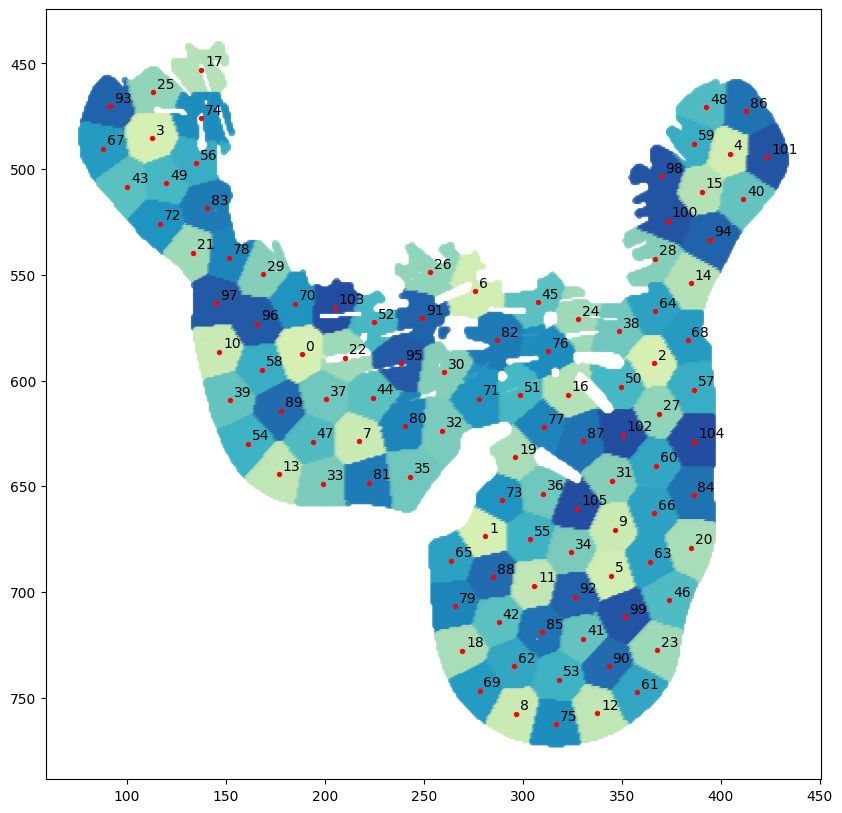

In [14]:
# Отображение кластеров - зон для каждой скважины
# палитра
from matplotlib.colors import ListedColormap
ylgnbu_limited = ListedColormap(plt.cm.YlGnBu(np.linspace(0.2, 0.8, 30)))

plt.figure(figsize=(10, 10))
# точки кластеров (x, y) - зоны скважин
plt.scatter(points[:, 0], points[:, 1], c=labels, cmap=ylgnbu_limited, s=18, linewidth=0.5, alpha=0.7)
# координаты центров кластеров
plt.scatter(centers[:, 0], centers[:, 1], c='red', marker='o', s=8, label="Центры кластеров")
# plt.legend()
plt.gca().invert_yaxis()
for i, (x, y) in enumerate(centers):
    plt.text(x+2, y-2, f'{i}', fontsize=10, ha='left', color='black')
plt.savefig(f"{save_directory}/cluster_project_well.png", dpi=500) 

### Шаг 2 - Поиск несвязанных зон (Multipolygon) в пределах кластера и их перераспределение
После кластеризации часть кластеров может быть не единым полигоном, а мультиполигоном (иметь несвязанные части). 

In [15]:
def convert_multipolygon(row, gdf_clusters, coef_area=0.4):
    """
    Функция преобразования MultiPolygon в Polygon - перераспределения несвязанных кластеров (MultiPolygon)
    Parameters
    ----------
    row - строка gdf_clusters
    gdf_clusters - GeoDataFrame с полигонами/мультиполигонами под проектные скважины
    coef_area - доля площади, необходимая для выделения самостоятельного полигона из мультиполигона

    Returns
    -------
    """
    geometry = row['geometry']
    if not isinstance(geometry, MultiPolygon):
        return  # Если не MultiPolygon, ничего не делаем
    zones = row['start_zones']  # исходные зоны мультиполигона
    cluster_area = geometry.area  # Общая площадь мультиполигона
    # Перебираем зоны в мультиполигоне
    for zone in zones:
        if zone.area / cluster_area >= coef_area:
            continue  # Зона достаточно крупная, остается самостоятельным кластером
        # Находим пересекающиеся полигоны, исключая текущий
        intersecting_polygons = gdf_clusters[(gdf_clusters.index != row.name) &
                                             (gdf_clusters.geometry.intersects(zone))].copy()
        if intersecting_polygons.empty:
            gdf_clusters.at[row.name, 'zones'].remove(zone)
            continue  # Нет пересекающихся кластеров

        # Добавляем расстояние до текущей зоны для сортировки
        intersecting_polygons['distance'] = intersecting_polygons.geometry.apply(zone.distance)
        intersecting_polygons = intersecting_polygons.sort_values(by='distance')
        zone_added = False  # Флаг для отслеживания успешного добавления зоны
        # Проверяем каждый пересекающийся кластер
        for idx, poly_row in intersecting_polygons.iterrows():
            surround_poly = poly_row['geometry']

            # Обработка зоны в случае MultiPolygon
            if isinstance(surround_poly, MultiPolygon):
                intersecting_polygon_zones = [nearest_zone for nearest_zone in surround_poly.geoms if zone.distance(nearest_zone) == 0]
            
            # Обработка зоны в случае Polygon
            elif isinstance(surround_poly, Polygon):
                intersecting_polygon_zones = [surround_poly]
            else:
                intersecting_polygon_zones = []
                print(f"Кластер скважины не Polygon/MultiPolygon")
                
            # Проверяем пересечение и размер зон
            for nearest_zone in intersecting_polygon_zones:
                # Проверяем, пересекается ли nearest_zone с zone и проверяем площадь зоны
                if (nearest_zone.intersects(zone) and nearest_zone.overlaps(zone) and
                    nearest_zone.area / surround_poly.area >= coef_area):
                    # Добавляем зону в gdf, если она еще не добавлена
                    if nearest_zone not in gdf_clusters.at[idx, 'zones']:
                        gdf_clusters.at[idx, 'zones'].append(nearest_zone)
                    gdf_clusters.at[idx, 'zones'].append(zone)
                    
                    # Удаляем зону из текущего кластера
                    gdf_clusters.at[row.name, 'zones'].remove(zone)
                    zone_added = True
                    break
                else:
                    continue  # Если не нашли подходящую зону, продолжаем

            if zone_added:
                break  # Выход из цикла по intersecting_polygons
            

        if not zone_added:
            if zone.area / cluster_area < coef_area: 
                # Удаляем зону из текущего кластера
                gdf_clusters.at[row.name, 'zones'].remove(zone)
                print(f"Зона {row.name} удалена. Её площадь составляет {zone.area / cluster_area} от всего кластера")
             
            else:
                print(f"Несвязанный кластер (MultiPolygon) не перераспределился! - {row.name}")

In [16]:
# Преобразуем точки в GeoSeries
gdf_points = gpd.GeoDataFrame(geometry=[Point(p) for p in points])

# Создаем буферы вокруг точек
gdf_buffers = gdf_points.buffer(1)

# Объединяем буферы по меткам кластеров
cluster_polygons = gdf_buffers.groupby(labels).apply(lambda x: x.union_all())

# GeoDataFrame с полученными кластерами/полигонами
gdf_clusters = gpd.GeoDataFrame(geometry=cluster_polygons).reset_index(drop=True)

# Добавляем столбец для геометрий MultiPolygon, чтобы перераспределить несвязанные кластеры
# zones - зоны мультиполигона
gdf_clusters['zones'] = gdf_clusters['geometry'].apply(
    lambda geom: list(geom.geoms) if isinstance(geom, MultiPolygon) else [])

# Вывод информации
for i, row in gdf_clusters.iterrows():
    if len(row['zones']) > 1:
        print(f"Кластер {i} содержит {len(row['zones'])} несвязанных зон")

import copy
gdf_clusters['start_zones'] = gdf_clusters['zones'].apply(lambda x: copy.deepcopy(x))

# Выделяем зоны в несвязанных кластерах (MultiPolygon) и перераспределяем их
gdf_clusters.apply(lambda row: convert_multipolygon(row, gdf_clusters), axis=1);

Кластер 6 содержит 2 несвязанных зон
Кластер 17 содержит 2 несвязанных зон
Кластер 22 содержит 2 несвязанных зон
Кластер 24 содержит 3 несвязанных зон
Кластер 50 содержит 2 несвязанных зон
Кластер 56 содержит 2 несвязанных зон
Кластер 71 содержит 2 несвязанных зон
Кластер 74 содержит 2 несвязанных зон
Кластер 80 содержит 2 несвязанных зон
Кластер 91 содержит 2 несвязанных зон
Кластер 92 содержит 2 несвязанных зон


In [17]:
# Объединяем перераспределенные зоны и преобразуем в Polygon
gdf_clusters['geometry'] = gdf_clusters.apply(lambda row: unary_union(row['zones']) if row['zones'] else row['geometry'], axis=1)
gdf_clusters = gdf_clusters.drop(columns=['zones', 'start_zones'])
gdf_clusters['centers'] = gdf_clusters['geometry'].centroid  # Центры новых полигонов

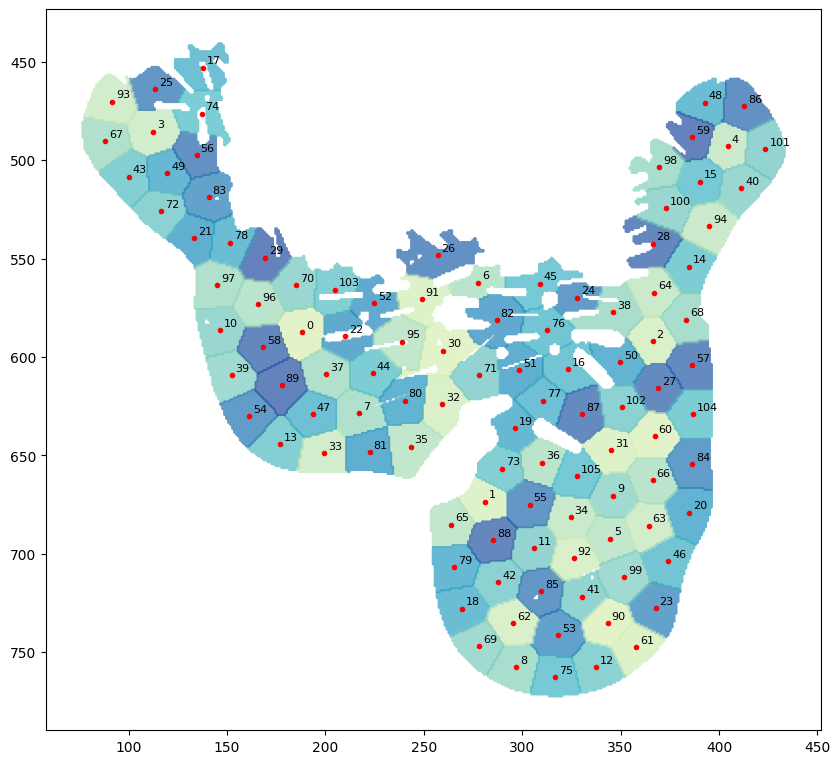

In [18]:
# Отображение новых кластеров
# палитра
from matplotlib.colors import ListedColormap
ylgnbu_limited = ListedColormap(plt.cm.YlGnBu(np.linspace(0.2, 0.8, 30)))

fig, ax = plt.subplots(figsize=(10, 10))
gdf_clusters.plot(ax=ax, cmap=ylgnbu_limited, linewidth=0.5, alpha=0.7)
# Добавление точек центров
centroids = gdf_clusters['centers'] 
for i, centroid in enumerate(centroids):
    x, y = centroid.x, centroid.y
    plt.plot(x, y, marker='o', color='red', markersize=3)  
    plt.text(x+2, y-2, f'{i}', fontsize=8, ha='left', color='black')  

plt.gca().invert_yaxis()
plt.savefig(f"{save_directory}/final_cluster_project_well.png", dpi=500)

### Шаг 3 - Подготовка данных по фактическим скважинам
Создаем геодатафрейм для исключения пересечения проектных и фактических скважин.  
Также фактические скважины нужны для определения длин и азимутов проектных горизонтальных скважин.

In [19]:
# подготовим фрейм с координатами для работы и преобразуем его в GeoDataFrame
gdf_fact_wells = gpd.GeoDataFrame(data_wells, geometry="LINESTRING_geo")
# горизонтальные фактические скважины
gdf_fact_wells_GS = gdf_fact_wells[gdf_fact_wells["well_type"] == "horizontal"].reset_index(drop=True)

### Шаг 4 - Проектные скважины
После получения кластеров для размещения проектных скважин, можно провести горизонтальные скважины через центры кластеров. Изначально предполагаем, что все проектные скважины – ГС.

In [20]:
# Полученные центры проектных скважин - центры кластеров
gdf_project = gdf_clusters.copy()
gdf_project['well_number'] = range(1, len(gdf_project) + 1)
gdf_project['well_marker'] = 'project'
gdf_project.rename(columns ={'centers':'POINT_T2_pix', 'geometry': 'cluster'}, inplace=True)
gdf_project.set_geometry("POINT_T2_pix", inplace=True)

#### **Шаг 4.1 - Определение средних параметров (азимут, длина) с фактических скважин окружения**
* Используя алгоритм k-ближайших соседей, определяем k-ближайших скважин к каждой проектной скважине (с учетом threshold).
* На основе параметров ближайших скважин определяем длину и азимут проектных скважин, как среднее k-ближайших фактических скважин.

In [21]:
# Функция для нахождения k ближайших ГС
def get_well_path_nearest_wells(center, gdf_fact_wells, k=5, threshold=50):
    """
    Получаем параметры k - ближайших фактических горизонтальных скважин
    Parameters
    ----------
    center - центр кластера скважины (POINT_T2_pix)
    gdf_fact_wells - gdf с фактическими скважинами
    threshold = 50 - максимальное расстояние для исключения скважины
                                                из ближайших скважин, пиксели
    Returns
    -------
    avg_azimuth - средний азимут по окружению
    avg_length - средняя длина по окружению
    """
    # Вычисляем расстояния до всех ГС
    distances = center.distance(gdf_fact_wells["LINESTRING_pix"])
    sorted_distances = distances.nsmallest(k)
    nearest_GS_index = [sorted_distances.index[0]] # Ближайшая скважина всегда включается
    
    for i in range(1, len(sorted_distances)):
        # Проверяем разницу с первой добавленной ближайшей скважиной
        if sorted_distances.iloc[i] - sorted_distances.iloc[0] < threshold:
            nearest_GS_index.append(sorted_distances.index[i])

    gdf_nearest_GS = gdf_fact_wells.loc[nearest_GS_index] # извлечение строк GeoDataFrame по индексам

    # Расчет параметров выбранного окружения
    avg_azimuth = gdf_nearest_GS.loc[(abs(gdf_nearest_GS['azimuth'] - gdf_nearest_GS['azimuth'].iloc[0]) <= 90)]['azimuth'].mean()
    avg_length = np.mean(gdf_nearest_GS['length_pix'])
 
    return avg_azimuth, avg_length

# Находим ближайшие фактические ГС для проектных точек и рассчитываем параметры по окружению
gdf_project[["azimuth", 'length_pix']] = gdf_project["POINT_T2_pix"].apply(
    lambda center: pd.Series(get_well_path_nearest_wells(center, gdf_fact_wells_GS)))

#### **Шаг 4.2 - Определение точек T1 и T3 для ГС и отображение**
На основе рассчитанных азимутов и длин проектных скважин проводим горизонтальные стволы через центры соответствующих кластеров таким образом, чтобы центр кластера был серединой проектной скважины.

In [22]:
def compute_t1_t3_points(row):
    """Расчет точек Т1 и Т3 на основе Т2 (центра) и азимута"""
    azimuth_rad = np.radians(row['azimuth'])
    half_length = row['length_pix'] / 2
    
    # Вычисление координат начальной и конечной точек
    x1 = row['POINT_T2_pix'].x - half_length * np.sin(azimuth_rad)
    y1 = row['POINT_T2_pix'].y + half_length * np.cos(azimuth_rad)
    x2 = row['POINT_T2_pix'].x + half_length * np.sin(azimuth_rad)
    y2 = row['POINT_T2_pix'].y - half_length * np.cos(azimuth_rad)

    return Point(x1, y1), Point(x2, y2)
    
# Получаем точки T1 и T3 на основе центров кластеров (T2)
gdf_project[['POINT_T1_pix', 'POINT_T3_pix']]  = gdf_project.apply(compute_t1_t3_points, axis=1, result_type='expand')    
# Получаем линии (горизонтальные стволы)
gdf_project['LINESTRING_pix'] = gdf_project.apply(lambda row: LineString([row['POINT_T1_pix'], row['POINT_T3_pix']]), axis=1)
gdf_project.set_geometry('LINESTRING_pix', inplace=True)

gdf_project['T1_x_pix'] = gdf_project['POINT_T1_pix'].apply(lambda point: point.x)
gdf_project['T1_y_pix'] = gdf_project['POINT_T1_pix'].apply(lambda point: point.y)
gdf_project['T3_x_pix'] = gdf_project['POINT_T3_pix'].apply(lambda point: point.x)
gdf_project['T3_y_pix'] = gdf_project['POINT_T3_pix'].apply(lambda point: point.y)

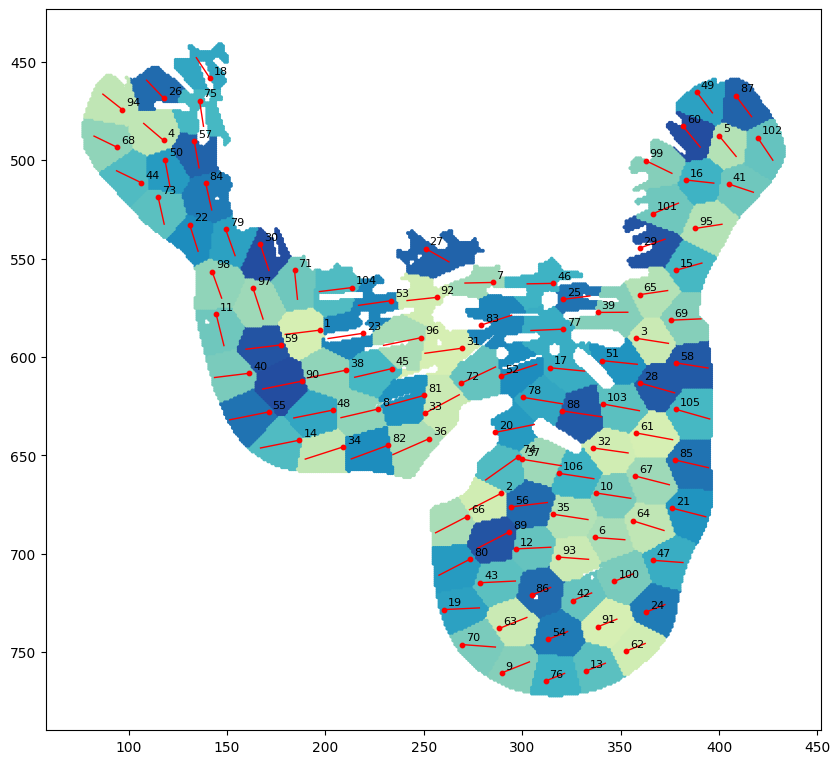

In [23]:
# Визуализация проектных скважин и кластеров
fig, ax = plt.subplots(figsize=(10, 10))

gdf_project.set_geometry("cluster").plot(ax=ax, cmap=ylgnbu_limited, linewidth=0.5) 

# Отображение проектных ГС по точкам T1 и T3 из GeoDataFrame
gdf_project.plot(ax=ax, color='red', linewidth=1)
gdf_project.set_geometry("POINT_T1_pix").plot(color='red', markersize=10, ax=ax)

x_t1, y_t1 = (gdf_project.T1_x_pix, gdf_project.T1_y_pix)

# Отображение имен скважин рядом с точками T1
for x, y, name in zip(x_t1, y_t1, gdf_project.well_number):
    plt.text(x + 2, y - 2, name, fontsize=8, ha='left')
    
plt.gca().invert_yaxis()  
plt.savefig(f"{save_directory}/init_project_well.png", dpi=500)

In [24]:
# Выпуклая оболочка для того, чтобы проектная скважина не выходила за её пределы
gdf_project['convex_hull'] = gdf_project['cluster'].apply(lambda x: x.convex_hull)

#### **Шаг 4.3 - Исключаем пересечение скважин**
Часть проектных скважин имеет пересечения с фактическим фондом (белые вытянутые пятна) и с другими проектными скважинами, поэтому расположение или длину таких скважин нужно скорректировать:
* подвигать
* повращать
* сократить длину

#### Определяем ориентацию скважины и порядок сдвига

In [25]:
def get_orientation(line):
    '''Определение ориентации скважины (вдоль x или y)'''
    x_diff = abs(line.coords[-1][0] - line.coords[0][0])
    y_diff = abs(line.coords[-1][1] - line.coords[0][1])
    
    if x_diff >= y_diff: 
        return 'x'
    return 'y'

def determine_shift_direction(proj_well, intersect_well):
    """Определение направления для сдвига (вверх/вниз/влево/вправо)
    в зависимости от расположения ближайшей пересекающей скважины"""
    proj_point, intersect_point = nearest_points(proj_well, intersect_well)
    directions = []
    # Если ориентация вдоль x
    if get_orientation(proj_well) == 'x':
        if intersect_point.y < proj_point.y:
            directions = ['down', 'up']
        else:
            directions = ['up', 'down']

        if intersect_point.x < proj_point.x:
            directions += ['right', 'left']
        else:
            directions += ['left', 'right']

    # Если ориентация вдоль y
    elif get_orientation(proj_well) == 'y':
        if intersect_point.x < proj_point.x:
            directions = ['right', 'left']
        else:
            directions = ['left', 'right']

        if intersect_point.y < proj_point.y:
            directions += ['down', 'up']
        else:
            directions += ['up', 'down']

    return directions

#### Двигаем пересекающиеся проектные скважины
Двигаем пересекающиеся проектные скважины в соответствии с полученным порядком направлений для сдвига с шагом равным 1 пиксель (*step_shift*) до тех пор, пока текущая проектная скважина не будет иметь пересечений с окружением и ствол не выйдет из выпуклой оболочки кластера более чем на *part_line_in*.

In [26]:
def shift_project_well(proj_row, nearest_intersected_well, gdf_fact_wells, other_proj_wells,
                       buffer_project_wells, part_line_in=0.7, step_shift=1, max_attempts=100):
    """
    Сдвиг проектной скважины в указанном направлении
    proj_row - строка gdf с проектными скважинами
    nearest_intersected_well - пересекающиеся скважины
    gdf_fact_wells - gdf с фактическими скважинами
    other_proj_wells - gdf с другими проектными скважинами
    part_line_in - необходимая доля проектной скважины в кластере
    step_shift - шаг сдвига, 1 пиксель
    """
    # Словарь с направлениями и сдвигами
    dict_directions = {'up': (0, -step_shift),
                       'down': (0, step_shift),
                       'right': (step_shift, 0),
                       'left': (-step_shift, 0)}

    original_position = proj_row['LINESTRING_pix']

    # Если исходная проектная скважина - не LINESTRING (не ГС)
    if not original_position.is_valid:
        original_position = Point(original_position.coords[0])

    # Определяем порядок направлений сдвига (вверх/вниз/влево/вправо)
    directions = determine_shift_direction(original_position, nearest_intersected_well['LINESTRING_pix'])
    Flag = False
    attempt_count = 0  # Счетчик попыток сдвига

    # Перебираем направления
    for direction in directions:
        new_position = original_position
        x_off, y_off = dict_directions[direction]

        # Сдвигаем в данном направлении пока есть пересечения с фактическим и/или проектным фондом
        while (gdf_fact_wells['buffer'].intersects(new_position.buffer(buffer_project_wells)).any() or
               other_proj_wells['buffer'].intersects(new_position.buffer(buffer_project_wells)).any()):
            # Сдвигаем в зависимости от направления
            new_position = translate(new_position, xoff=x_off, yoff=y_off)
            attempt_count += 1  # Увеличиваем счетчик попыток

            # Если количество попыток превышает лимит, выходим
            if attempt_count > max_attempts:
                print("Превышен лимит попыток сдвига, скважина не может быть сдвинута.")
                return original_position, False  # Сдвиг не удался

            # Смена Flag в случае, если изначально центр и больше 0,7*ГС вне кластера
            if proj_row['cluster'].intersection(new_position).length >= (part_line_in * proj_row['length_pix']):
                if proj_row['cluster'].contains(new_position.centroid):
                    Flag = True

            # Меняем направление, если скважина начала выходить из кластера на >30%
            if (not proj_row['cluster'].intersection(new_position).length >=
                    (part_line_in * proj_row['length_pix']) and Flag or
                    not proj_row['cluster'].contains(new_position.centroid) and Flag or
                    not proj_row['convex_hull'].intersection(new_position).length >=
                        (part_line_in * proj_row['length_pix']) or
                    not proj_row['convex_hull'].contains(new_position.centroid)):
                Flag = False
                break

        # Проверка, что сдвинутая скважина не пересекает другие буферы
        if not (gdf_fact_wells['buffer'].intersects(new_position.buffer(buffer_project_wells)).any() or
                other_proj_wells['buffer'].intersects(new_position.buffer(buffer_project_wells)).any()):
            return new_position, True  # Сдвиг удался

    return original_position, False  # Сдвиг не удался

Если решение в результате сдвига не нашлось, т.е. проектная скважина имеет пересечение с окружающим фондом, либо число попыток attempt_count > max_attempts (=100), то возвращаемся к исходному положению проектной скважины и начинаем её вращать, если она ГС (ГС > 300 м, иначе ННС).

#### Вращаем пересекающиеся проектные скважины
Вращаем проектные скважины, которые имеют пересечения с другим фондом и которым сдвиг не помог, относительно центра исходной траектории (центр кластера).
* Шаг поворота скважины (*step_angle*) – 5 градусов.
* Диапазон вращения (*max_angle*) – +45/-45 градусов включительно относительно исходного положения.

In [27]:
def rotate_project_well(original_position, gdf_fact_wells, other_proj_wells, buffer_project_wells,
                        max_angle=46, step_angle=5):
    """
    Поворот проектной скважины в интервале +45/-45 градусов
    original_position - исходное положение проектной скважины
    gdf_fact_wells - gdf с фактическими скважинами
    other_proj_wells - gdf с другими проектными скважинами
    max_angle - максимальный угол вращения
    step_angle - шаг вращения
    """
    angle = 0
    change_direction = False

    # Вращаем скважины до предельного угла
    while (max_angle >= 0 and angle < max_angle) or (max_angle <= 0 and angle > max_angle):
        # Поворачиваем скважины вокруг её центра
        new_position = rotate(original_position, angle, origin=original_position.centroid)

        # Если нет пересечений, то решение найдено
        if not (gdf_fact_wells['buffer'].intersects(new_position.buffer(buffer_project_wells)).any() or
                other_proj_wells['buffer'].intersects(new_position.buffer(buffer_project_wells)).any()):
            return new_position, True

        angle += step_angle

        if abs(angle) > abs(max_angle):
            if change_direction:
                break
            change_direction = True
            angle = 0
            max_angle = -max_angle
            step_angle = -step_angle

    return original_position, False  # если не удалось повернуть

#### Сокращаем длину пересекающихся проектных скважин
* Если сдвиг и вращение не дали результата, то сокращаем длину скважины на 10% (step_length = 0.1) от исходной длины (original_length) относительно центра скважины. Т.е. центр скважины (POINT_T2) не изменяется после уменьшения длины, а изменяются точки T1 и T3.  
* Сокращение длины происходит только, если длина скважины больше min_length = 300 метров, иначе горизонтальная проектная скважина становится наклонно-направленной ННС.

In [28]:
def short_well(trajectory, new_length):
    """Функция для сокращения линии до определенной длины"""
    # Проверка длины линии
    if trajectory.length < new_length:
        return Point(trajectory.centroid)  # ННС, если ГС уже короче 300 м

    half_length = new_length / 2
    start_point = trajectory.interpolate(trajectory.length / 2 + half_length, normalized=False)
    end_point = trajectory.interpolate(trajectory.length / 2 - half_length, normalized=False)

    # Проверка, нужно ли поменять местами start_point и end_point
    if start_point.distance(Point(trajectory.coords[0])) > end_point.distance(Point(trajectory.coords[0])):
        start_point, end_point = end_point, start_point

    # Создаем новую траекторию с учетом сокращения относительно центра
    new_trajectory = LineString([start_point, end_point])
    return new_trajectory

In [29]:
def update_and_shift_proj_wells(gdf_project, gdf_fact_wells, intersecting_proj_wells, default_size_pixel,
                                buffer_project_wells, min_length=300):
    """
    Функция поиска начального расположения проектных скважин без пересечений
    gdf_project
    gdf_fact_wells
    intersecting_proj_wells - пересекающиеся проектные скважины
    min_length=300 - минимальная длина ГС, иначе ННС
    """
    # Перебираем пересекающиеся с другим фондом проектные скважины
    for proj_idx, proj_row in intersecting_proj_wells.iterrows():
        other_proj_wells = gdf_project.drop(proj_idx)

        intersected_fact_wells = gdf_fact_wells[gdf_fact_wells['buffer'].intersects(proj_row['buffer'])]
        intersected_proj_wells = other_proj_wells[other_proj_wells['buffer'].intersects(proj_row['buffer'])]
        intersected_wells = pd.concat([intersected_fact_wells, intersected_proj_wells])

        # Находим ближайшую пересеченную скважину
        if not intersected_wells.empty:
            intersected_wells['distance'] = intersected_wells['LINESTRING_pix'].apply(
                lambda x: proj_row['LINESTRING_pix'].distance(x))
            min_distance = intersected_wells['distance'].min()
            nearest_intersected_well = intersected_wells[intersected_wells['distance'] == min_distance].copy().iloc[0]
        else:
            continue

        original_position = proj_row['LINESTRING_pix']
        new_position = original_position
        is_updated = False  # Флаг для управления завершением цикла
        original_length = original_position.length  # Сохраняем первоначальную длину
        new_length = original_length

        while not is_updated:
            # Двигаем проектную скважину
            new_position, is_updated = shift_project_well(proj_row, nearest_intersected_well, gdf_fact_wells,
                                                          other_proj_wells, buffer_project_wells)
            # Вращаем проектную скважину, если решение не нашлось и она не ННС
            if not is_updated and proj_row['LINESTRING_pix'].length > 0:
                new_position, is_updated = rotate_project_well(original_position, gdf_fact_wells,
                                                               other_proj_wells, buffer_project_wells)
            # Удаление проектной скважины из-за невозможности расположить её
            if not is_updated and new_length == 0:
                gdf_project.at[proj_idx, 'well_marker'] = 'удалить'
                # gdf_project.drop(proj_idx, inplace=True)
                break

            # Уменьшаем длины проектной скважины
            new_length -= 0.1 * original_length  # Уменьшаем длину на 10%
            if new_length < min_length / default_size_pixel:
                new_length = 0

            if not is_updated:
                new_position = short_well(proj_row['LINESTRING_pix'], new_length)
                proj_row['LINESTRING_pix'] = new_position
                proj_row['length_pix'] = new_position.length
                proj_row['buffer'] = new_position.buffer(buffer_project_wells)

        # Обновление данных
        if is_updated:
            gdf_project.at[proj_idx, 'buffer'] = new_position.buffer(buffer_project_wells)
            gdf_project.at[proj_idx, 'LINESTRING_pix'] = new_position
            gdf_project.at[proj_idx, 'length_pix'] = new_position.length

* После сокращения длины проектной скважины повторяем все шаги пункта 4.3, описанные выше (сдвиг скважины, вращение, сокращение длины), до тех пор, пока не найдется решение (не будет пересечений скважин).  
* Если решение не нашлось, то проектная скважина удаляется.

In [30]:
buffer_project_wells = 200 / default_size_pixel  # условный буфер проектной скважины для избежания пересечений с фондом, м
gdf_fact_wells.set_geometry("LINESTRING_pix", inplace=True)
gdf_project.set_geometry("LINESTRING_pix", inplace=True)

# Создаем буферы, чтобы искать пересечения зон скважин (для фактических скважин можно использовать радиусы дренирования)
gdf_fact_wells['buffer'] = gdf_fact_wells.geometry.buffer(gdf_fact_wells["r_eff"] / default_size_pixel)
gdf_project['buffer'] = gdf_project.geometry.buffer(buffer_project_wells)

intersecting_proj_wells = gdf_project[gdf_project.apply(lambda row: (gdf_fact_wells['buffer'].intersects(row['buffer']).any() or
        gdf_project[gdf_project.index != row.name]['buffer'].intersects(row['buffer']).any()), axis=1)]

# Смещаем, вращаем, сокращаем пересекающихся проектный фонд скважин, при наличии такового
if not intersecting_proj_wells.empty:
    update_and_shift_proj_wells(gdf_project, gdf_fact_wells, intersecting_proj_wells, default_size_pixel,
                                buffer_project_wells)
    gdf_project = gdf_project[gdf_project['well_marker'] != 'удалить']

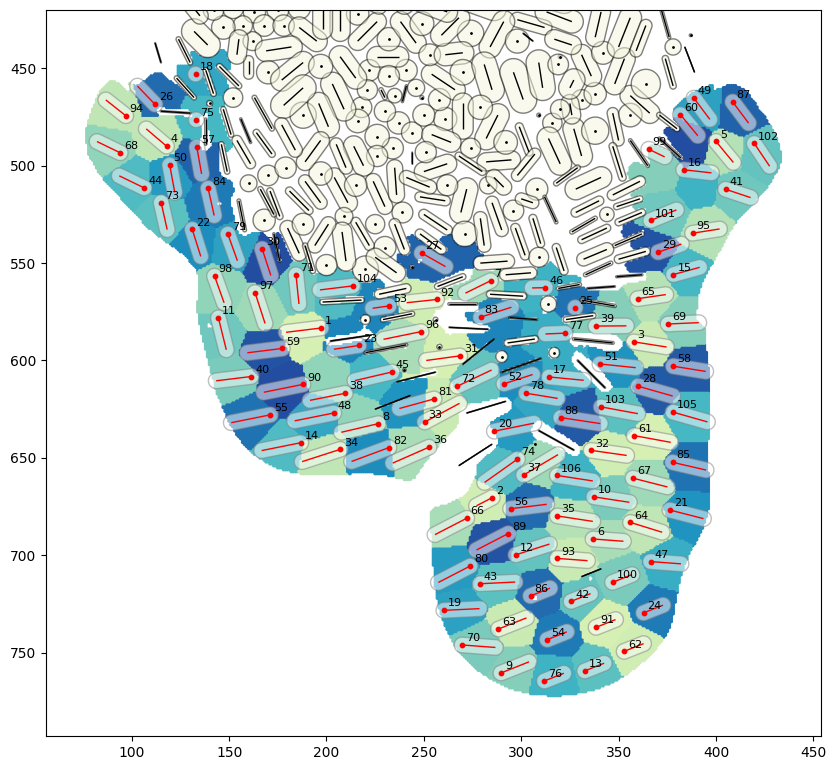

In [31]:
# Визуализация проектных скважин и кластеров
fig, ax = plt.subplots(figsize=(10, 10))

gdf_project["cluster"].plot(ax=ax, cmap=ylgnbu_limited, linewidth=0.5) 

gdf_project["POINT_T1_pix"] = gdf_project["LINESTRING_pix"].apply(lambda x: Point(x.coords[0]))
gdf_project["POINT_T3_pix"] = gdf_project["LINESTRING_pix"].apply(lambda x: Point(x.coords[-1]))
gdf_project.loc[gdf_project["POINT_T1_pix"] == gdf_project["POINT_T3_pix"], "well_type"] = "vertical"
gdf_project.loc[gdf_project["POINT_T1_pix"] != gdf_project["POINT_T3_pix"], "well_type"] = "horizontal"

# Новый буфер после смещения
gdf_project['buffer'] = gdf_project.geometry.buffer(buffer_project_wells)
gdf_project.set_geometry("buffer").plot(edgecolor="gray", facecolor="white", alpha=0.5, ax=ax)
gdf_fact_wells.set_geometry("buffer").plot(edgecolor="black", facecolor="beige", alpha=0.5, ax=ax)
gdf_fact_wells['LINESTRING_pix'].plot(ax=ax, color='black', linewidth=1, markersize=1)

# Отображение проектных ГС по точкам T1 и T3 из GeoDataFrame
gdf_project['LINESTRING_pix'].plot(ax=ax, color='red', linewidth=1, markersize=1)

# # Создание отдельного столбца с точкой T1, взятой как начальная точка LineString
# gdf_project.loc[:, 'POINT_T1_pix']  = gdf_project['LINESTRING_pix'].apply(lambda x: x.coords[0] if x is not None else None)

# Разделение координат T1 на x и y
gdf_project.loc[:, 'T1_x_pix'] = gdf_project['POINT_T1_pix'].apply(lambda point: point.x)
gdf_project.loc[:, 'T1_y_pix'] = gdf_project['POINT_T1_pix'].apply(lambda point: point.y)

# Отображение точек T1 на графике
gdf_project.set_geometry(gpd.points_from_xy(gdf_project['T1_x_pix'], gdf_project['T1_y_pix'])).plot(color='red', markersize=10, ax=ax)

# Добавление текста с именами скважин рядом с точками T1
for x, y, name in zip(gdf_project['T1_x_pix'], gdf_project['T1_y_pix'], gdf_project['well_number']):
    if x is not None and y is not None:
        plt.text(x + 2, y - 2, name, fontsize=8, ha='left')
        
min_x, min_y, max_x, max_y = gdf_project["cluster"].total_bounds        
ax.set_ylim(min_y-20, max_y+20)
ax.set_xlim(min_x-20, max_x+20)
plt.gca().invert_yaxis()  
plt.savefig(f"{save_directory}/final_init_project_well.png", dpi=500)